# Code for Comparing CNN Models with Transfer Learning

This code is intended to compare several CNN models with transfer learning for solid data with 3 classes: **"high," "medium,"** and **"low"** concentrations of solid.

## Selected Models for Comparison

For a comprehensive comparison, the following models will be used to cover a wide range of architectures:

- **AlexNet** - Basic reference.
- **EfficientNet-B4** - To evaluate modern efficiency and accuracy.
- **MobileNetV2** - To assess performance in lightweight models.
- **SqueezeNet** - Lightweight model.


In [24]:
# Import Packages
import torch
import torchvision
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader, random_split
import numpy as np
import time
import os
import shutil

In [25]:
# Setting Hyperparameters for Equal Conditions
# Hyperparameters
# Adam Optimizer
lr=0.005
num_epochs = 50
batch_size = 50

In [26]:
# Transformations to Make Images Suitable for 
# AlexNet, VGG16, ResNet50, DenseNet121, MobileNetV2 
# All require 244x244 pixels
transform = transforms.Compose([
    transforms.Resize(256),  # Resize
    transforms.CenterCrop(244),  # Center crop
    transforms.ToTensor(),  # Convert image from PIL (Python Imaging Library) to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization and standardization
])

In [27]:
# Assign a class according to the folder name
# Read images


def is_image_file(filename):
    valid_extensions = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp']
    return any(filename.endswith(extension) for extension in valid_extensions)

data = 'C:/Users/Itz/Documents/DOCTORADO/ART-SS-TL-EV/datasets/'
dataset = ImageFolder(root=data, transform=transform, is_valid_file=is_image_file)
#data = 'C:/Users/Itz/Documents/DOCTORADO/ART-SS-TL-EV/datasets/'               # Dataset path
# Create an ImageFolder for the data
#dataset = ImageFolder(root=data, transform=transform)

# Randomly select images,
# get their indices
indices = {label: np.where(np.array(dataset.targets) == label)[0] for label in range(len(dataset.classes))}

# Split the indices for each class into training and testing
train_indices = []
test_indices = []
for label, idx in indices.items():
    np.random.shuffle(idx)
    train_size = int(0.9 * len(idx))
    train_indices.extend(idx[:train_size])
    test_indices.extend(idx[train_size:])

# Create training and testing subsets with the obtained indices
train_data = Subset(dataset, train_indices)
test_data = Subset(dataset, test_indices)

# Create DataLoaders for the training and testing sets
train_loader = DataLoader(train_data, batch_size=50, shuffle=True)
test_loader = DataLoader(test_data, batch_size=50, shuffle=False)  # shuffle is false to maintain the labels of the data

# Check the number of samples in each set
print(f"Number of training samples: {len(train_data)}")
print(f"Number of testing samples: {len(test_data)}")


Number of training samples: 5862
Number of testing samples: 653


In [28]:
# Verifying the detected classes
num_classes = len(dataset.classes)
print("The number of classes is", num_classes)
class_names = dataset.classes  # Verifying the number of classes
print("The classes are:", class_names)  # Verifying the name of each class

The number of classes is 3
The classes are: ['1Alta', '2Media', '3Baja']


In [29]:
# Deleting existing pretrained networks from the system to ensure 
# the network uses the weights obtained from PyTorch (original weights of the network)

# Path to the cache directory
cache_dir = os.path.expanduser('~/.cache/torch/hub/checkpoints')

# Prefix of the cache file name for AlexNet
alexnet_filename_prefix = 'alexnet'

# Remove only AlexNet cache files if they exist
if os.path.exists(cache_dir):
    for filename in os.listdir(cache_dir):
        if alexnet_filename_prefix in filename:
            file_path = os.path.join(cache_dir, filename)
            if os.path.isfile(file_path):
                os.remove(file_path)
                print(f"Cache file removed: {file_path}")
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
                print(f"Cache directory removed: {file_path}")
else:
    print(f"Cache directory not found at: {cache_dir}")

# Download pretrained AlexNet model
alexnet_model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)

# Replacing the final layer with the proposed classification
alexnet_model.classifier[6] = nn.Sequential(
    nn.Linear(alexnet_model.classifier[6].in_features, num_classes)
)

# Display the architecture of the modified model
print(alexnet_model)


Cache file removed: C:\Users\Itz/.cache/torch/hub/checkpoints\alexnet-owt-7be5be79.pth


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\Itz/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:35<00:00, 6.94MB/s] 


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [30]:
# Deleting existing pretrained networks from the system to ensure 
# the network uses the weights obtained from PyTorch (original weights of the network)
# # Path to the cache directory
cache_dir = os.path.expanduser('~/.cache/torch/hub/checkpoints')

# Prefix of the cache file name for MobileNetV2
mobilenetv2_filename_prefix = 'mobilenet_v2'

# Remove only MobileNetV2 cache files if they exist
for filename in os.listdir(cache_dir):
    if filename.startswith(mobilenetv2_filename_prefix):
        file_path = os.path.join(cache_dir, filename)
        if os.path.isfile(file_path):
            os.remove(file_path)
            print(f"Cache file removed: {file_path}")
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
            print(f"Cache directory removed: {file_path}")
    else:
        print(f"Cache file for MobileNetV2 not found at: {filename}")

# Download pretrained MobileNetV2 model
mobilenetv2_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

# Replacing the final layer with the proposed classification
mobilenetv2_model.classifier[1] = nn.Linear(mobilenetv2_model.classifier[1].in_features, num_classes)

# Display the architecture of the modified model
print(mobilenetv2_model)


Cache file for MobileNetV2 not found at: alexnet-owt-7be5be79.pth
Cache file for MobileNetV2 not found at: efficientnet_b0_rwightman-7f5810bc.pth
Cache file removed: C:\Users\Itz/.cache/torch/hub/checkpoints\mobilenet_v2-7ebf99e0.pth
Cache file for MobileNetV2 not found at: squeezenet1_0-b66bff10.pth


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to C:\Users\Itz/.cache\torch\hub\checkpoints\mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:02<00:00, 6.04MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [31]:
# Deleting existing pretrained networks from the system to ensure 
# the network uses the weights obtained from PyTorch (original weights of the network)
# Path to the cache directory
cache_dir = os.path.expanduser('~/.cache/torch/hub/checkpoints')

# Prefix of the cache file name for EfficientNet-B0
efficientnet_b0_filename_prefix = 'efficientnet_b0'

# Remove only EfficientNet-B0 cache files if they exist
for filename in os.listdir(cache_dir):
    if filename.startswith(efficientnet_b0_filename_prefix):
        file_path = os.path.join(cache_dir, filename)
        if os.path.isfile(file_path):
            os.remove(file_path)
            print(f"Cache file removed: {file_path}")
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
            print(f"Cache directory removed: {file_path}")
    else:
        print(f"Cache file for EfficientNet-B0 not found at: {filename}")

# Download pretrained EfficientNet-B0 model
efficientnet_b0_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

# Replacing the final layer with the proposed classification
efficientnet_b0_model.classifier[1] = nn.Linear(efficientnet_b0_model.classifier[1].in_features, num_classes)

# Display the architecture of the modified model
print(efficientnet_b0_model)

Cache file for EfficientNet-B0 not found at: alexnet-owt-7be5be79.pth
Cache file removed: C:\Users\Itz/.cache/torch/hub/checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
Cache file for EfficientNet-B0 not found at: mobilenet_v2-7ebf99e0.pth
Cache file for EfficientNet-B0 not found at: squeezenet1_0-b66bff10.pth


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\Itz/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:03<00:00, 6.32MB/s]

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [32]:
from torchvision.models import squeezenet1_0, SqueezeNet1_0_Weights
# Deleting existing pretrained networks from the system to ensure 
# the network uses the weights obtained from PyTorch (original weights of the network)
# Path to the cache directory
cache_dir = os.path.expanduser('~/.cache/torch/hub/checkpoints')

# Prefix of the cache file name for SqueezeNet
squeezenet_filename_prefix = 'squeezenet1_0'

# Remove only SqueezeNet cache files if they exist
for filename in os.listdir(cache_dir):
    if filename.startswith(squeezenet_filename_prefix):
        file_path = os.path.join(cache_dir, filename)
        if os.path.isfile(file_path):
            os.remove(file_path)
            print(f"Cache file removed: {file_path}")
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
            print(f"Cache directory removed: {file_path}")
    else:
        print(f"Cache file for SqueezeNet not found at: {filename}")

# Download pretrained SqueezeNet1_0 model
squeezenet_model = squeezenet1_0(weights=SqueezeNet1_0_Weights.DEFAULT)

# Replacing the final layer with the proposed classification
# In SqueezeNet, the final layer is `classifier`, which is an `nn.Conv2d`
# We need to change the number of output channels in `classifier` to match `num_classes`
squeezenet_model.classifier[1] = nn.Conv2d(in_channels=512, out_channels=num_classes, kernel_size=(1, 1))

# Display the architecture of the modified model
print(squeezenet_model)


Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to C:\Users\Itz/.cache\torch\hub\checkpoints\squeezenet1_0-b66bff10.pth


Cache file for SqueezeNet not found at: alexnet-owt-7be5be79.pth
Cache file for SqueezeNet not found at: efficientnet_b0_rwightman-7f5810bc.pth
Cache file for SqueezeNet not found at: mobilenet_v2-7ebf99e0.pth
Cache file removed: C:\Users\Itz/.cache/torch/hub/checkpoints\squeezenet1_0-b66bff10.pth


100%|██████████| 4.78M/4.78M [00:00<00:00, 5.56MB/s]

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [33]:
# Calculate metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

# Function to calculate metrics
def calculate_metrics(all_labels, all_preds):
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)
    return accuracy, precision, recall, f1, conf_matrix

# Function to format time
def format_time(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"{hours}h {minutes}m {seconds}s"


## Training and Validation of AlexNet

In [ ]:
## Training and Validation of AlexNet
# Parameters
num_epochs = num_epochs
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialization of the AlexNet model
alexnet_model = alexnet_model.to(device)

# Optimizer and Criterion
optimizer_alexnet = optim.Adam(alexnet_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# Metrics history
alexnet_train_acc_history = []
alexnet_val_acc_history = []
alexnet_train_loss_history = []
alexnet_val_loss_history = []

# Measure training time
star_time_alexnet_train = time.time()

# Training the model
for epoch in range(num_epochs):
    alexnet_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    all_preds_train_alexnet = []
    all_labels_train_alexnet = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_alexnet.zero_grad()
        outputs = alexnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_alexnet.step()
        running_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Collect predictions and labels for training phase metrics
        all_preds_train_alexnet.extend(predicted.cpu().numpy())
        all_labels_train_alexnet.extend(labels.cpu().numpy())

    epoch_loss_alexnet = running_loss / len(train_loader.dataset)
    epoch_acc_alexnet = correct_train / total_train
    alexnet_train_loss_history.append(epoch_loss_alexnet)
    alexnet_train_acc_history.append(epoch_acc_alexnet)

    print(f"Epoch [{epoch+1}/{num_epochs}] for AlexNet - Loss: {epoch_loss_alexnet:.4f}, Accuracy: {epoch_acc_alexnet:.4f}")

    # Evaluation on validation set
    alexnet_model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    all_preds_val_alexnet = []
    all_labels_val_alexnet = []
    all_probs_val_alexnet = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = alexnet_model(inputs)
            probs = torch.softmax(outputs, dim=1)  # Probabilities of each class
            _, predicted = torch.max(outputs, 1)

            all_probs_val_alexnet.extend(probs.cpu().numpy())
            all_preds_val_alexnet.extend(predicted.cpu().numpy())
            all_labels_val_alexnet.extend(labels.cpu().numpy())
            
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss_alexnet = running_val_loss / len(test_loader.dataset)
    epoch_val_acc_alexnet = correct_val / total_val
    alexnet_val_loss_history.append(epoch_val_loss_alexnet)
    alexnet_val_acc_history.append(epoch_val_acc_alexnet)
    print(f"Validation Loss: {epoch_val_loss_alexnet:.4f}, Validation Accuracy: {epoch_val_acc_alexnet:.4f}")

    # Calculate metrics for validation phase
    accuracy_val_alexnet, precision_val_alexnet, recall_val_alexnet, f1_val_alexnet, _ = calculate_metrics(all_labels_val_alexnet, all_preds_val_alexnet)
    print(f"AlexNet Validation Metrics: Accuracy: {accuracy_val_alexnet:.4f}, Precision: {precision_val_alexnet:.4f}, Recall: {recall_val_alexnet:.4f}, F1-score: {f1_val_alexnet:.4f}")

end_time_alexnet_train = time.time()
# Calculate and display training time:
alexnet_training_time = format_time(end_time_alexnet_train - star_time_alexnet_train)

print(f"Total training time for AlexNet is: {alexnet_training_time}")

alexnet_training_time = end_time_alexnet_train - star_time_alexnet_train
# Save metrics 
alexnet_val_metrics = {
    "Accuracy": accuracy_val_alexnet,
    "Precision": precision_val_alexnet, 
    "Recall": recall_val_alexnet,
    "F1-score": f1_val_alexnet
} 

# Save results for later comparison
alexnet_results = {
    "train_loss": alexnet_train_loss_history,
    "train_acc": alexnet_train_acc_history,
    "val_loss": alexnet_val_loss_history,
    "val_acc": alexnet_val_acc_history,
    "all_preds_val": all_preds_val_alexnet,
    "all_labels_val": all_labels_val_alexnet,
    "all_probs_val": all_probs_val_alexnet
}


Epoch [1/50] for AlexNet - Loss: 13.4197, Accuracy: 0.4625
Validation Loss: 0.9461, Validation Accuracy: 0.5513
AlexNet Validation Metrics: Accuracy: 0.5513, Precision: 0.3039, Recall: 0.5513, F1-score: 0.3918


c:\Users\Itz\anaconda3\envs\ANNs_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [2/50] for AlexNet - Loss: 1.6823, Accuracy: 0.5005
Validation Loss: 0.8801, Validation Accuracy: 0.5513
AlexNet Validation Metrics: Accuracy: 0.5513, Precision: 0.3039, Recall: 0.5513, F1-score: 0.3918


c:\Users\Itz\anaconda3\envs\ANNs_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [3/50] for AlexNet - Loss: 1.3943, Accuracy: 0.5353
Validation Loss: 0.9851, Validation Accuracy: 0.5513
AlexNet Validation Metrics: Accuracy: 0.5513, Precision: 0.3039, Recall: 0.5513, F1-score: 0.3918


c:\Users\Itz\anaconda3\envs\ANNs_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [4/50] for AlexNet - Loss: 1.0704, Accuracy: 0.5512
Validation Loss: 0.9641, Validation Accuracy: 0.5513
AlexNet Validation Metrics: Accuracy: 0.5513, Precision: 0.3039, Recall: 0.5513, F1-score: 0.3918


c:\Users\Itz\anaconda3\envs\ANNs_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [5/50] for AlexNet - Loss: 0.9836, Accuracy: 0.5512
Validation Loss: 0.9613, Validation Accuracy: 0.5513
AlexNet Validation Metrics: Accuracy: 0.5513, Precision: 0.3039, Recall: 0.5513, F1-score: 0.3918


c:\Users\Itz\anaconda3\envs\ANNs_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [6/50] for AlexNet - Loss: 0.9665, Accuracy: 0.5524
Validation Loss: 0.9608, Validation Accuracy: 0.5513
AlexNet Validation Metrics: Accuracy: 0.5513, Precision: 0.3039, Recall: 0.5513, F1-score: 0.3918


c:\Users\Itz\anaconda3\envs\ANNs_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [7/50] for AlexNet - Loss: 0.9592, Accuracy: 0.5525
Validation Loss: 0.9608, Validation Accuracy: 0.5513
AlexNet Validation Metrics: Accuracy: 0.5513, Precision: 0.3039, Recall: 0.5513, F1-score: 0.3918


c:\Users\Itz\anaconda3\envs\ANNs_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [8/50] for AlexNet - Loss: 1.0482, Accuracy: 0.5525
Validation Loss: 0.9610, Validation Accuracy: 0.5513
AlexNet Validation Metrics: Accuracy: 0.5513, Precision: 0.3039, Recall: 0.5513, F1-score: 0.3918


c:\Users\Itz\anaconda3\envs\ANNs_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [9/50] for AlexNet - Loss: 0.9631, Accuracy: 0.5520
Validation Loss: 0.9608, Validation Accuracy: 0.5513
AlexNet Validation Metrics: Accuracy: 0.5513, Precision: 0.3039, Recall: 0.5513, F1-score: 0.3918


c:\Users\Itz\anaconda3\envs\ANNs_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [10/50] for AlexNet - Loss: 0.9677, Accuracy: 0.5525
Validation Loss: 0.9608, Validation Accuracy: 0.5513
AlexNet Validation Metrics: Accuracy: 0.5513, Precision: 0.3039, Recall: 0.5513, F1-score: 0.3918


c:\Users\Itz\anaconda3\envs\ANNs_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [11/50] for AlexNet - Loss: 0.9648, Accuracy: 0.5525
Validation Loss: 0.9608, Validation Accuracy: 0.5513
AlexNet Validation Metrics: Accuracy: 0.5513, Precision: 0.3039, Recall: 0.5513, F1-score: 0.3918


c:\Users\Itz\anaconda3\envs\ANNs_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [12/50] for AlexNet - Loss: 1.1149, Accuracy: 0.5488
Validation Loss: 0.9608, Validation Accuracy: 0.5513
AlexNet Validation Metrics: Accuracy: 0.5513, Precision: 0.3039, Recall: 0.5513, F1-score: 0.3918


c:\Users\Itz\anaconda3\envs\ANNs_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [13/50] for AlexNet - Loss: 0.9621, Accuracy: 0.5498
Validation Loss: 0.9608, Validation Accuracy: 0.5513
AlexNet Validation Metrics: Accuracy: 0.5513, Precision: 0.3039, Recall: 0.5513, F1-score: 0.3918


c:\Users\Itz\anaconda3\envs\ANNs_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [14/50] for AlexNet - Loss: 0.9648, Accuracy: 0.5507
Validation Loss: 0.9608, Validation Accuracy: 0.5513
AlexNet Validation Metrics: Accuracy: 0.5513, Precision: 0.3039, Recall: 0.5513, F1-score: 0.3918


c:\Users\Itz\anaconda3\envs\ANNs_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [15/50] for AlexNet - Loss: 0.9595, Accuracy: 0.5525
Validation Loss: 0.9608, Validation Accuracy: 0.5513
AlexNet Validation Metrics: Accuracy: 0.5513, Precision: 0.3039, Recall: 0.5513, F1-score: 0.3918


c:\Users\Itz\anaconda3\envs\ANNs_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [16/50] for AlexNet - Loss: 0.9624, Accuracy: 0.5525
Validation Loss: 0.9611, Validation Accuracy: 0.5513
AlexNet Validation Metrics: Accuracy: 0.5513, Precision: 0.3039, Recall: 0.5513, F1-score: 0.3918


c:\Users\Itz\anaconda3\envs\ANNs_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [17/50] for AlexNet - Loss: 0.9594, Accuracy: 0.5525
Validation Loss: 0.9608, Validation Accuracy: 0.5513
AlexNet Validation Metrics: Accuracy: 0.5513, Precision: 0.3039, Recall: 0.5513, F1-score: 0.3918


c:\Users\Itz\anaconda3\envs\ANNs_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [18/50] for AlexNet - Loss: 0.9615, Accuracy: 0.5512
Validation Loss: 0.9608, Validation Accuracy: 0.5513
AlexNet Validation Metrics: Accuracy: 0.5513, Precision: 0.3039, Recall: 0.5513, F1-score: 0.3918


c:\Users\Itz\anaconda3\envs\ANNs_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [19/50] for AlexNet - Loss: 0.9677, Accuracy: 0.5529
Validation Loss: 0.9608, Validation Accuracy: 0.5513
AlexNet Validation Metrics: Accuracy: 0.5513, Precision: 0.3039, Recall: 0.5513, F1-score: 0.3918


c:\Users\Itz\anaconda3\envs\ANNs_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [20/50] for AlexNet - Loss: 1.0535, Accuracy: 0.5527
Validation Loss: 0.9059, Validation Accuracy: 0.5513
AlexNet Validation Metrics: Accuracy: 0.5513, Precision: 0.3039, Recall: 0.5513, F1-score: 0.3918


c:\Users\Itz\anaconda3\envs\ANNs_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [21/50] for AlexNet - Loss: 7.7536, Accuracy: 0.5524
Validation Loss: 0.9609, Validation Accuracy: 0.5513
AlexNet Validation Metrics: Accuracy: 0.5513, Precision: 0.3039, Recall: 0.5513, F1-score: 0.3918


c:\Users\Itz\anaconda3\envs\ANNs_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [22/50] for AlexNet - Loss: 2.0265, Accuracy: 0.5522
Validation Loss: 0.9610, Validation Accuracy: 0.5513
AlexNet Validation Metrics: Accuracy: 0.5513, Precision: 0.3039, Recall: 0.5513, F1-score: 0.3918


c:\Users\Itz\anaconda3\envs\ANNs_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [23/50] for AlexNet - Loss: 6.0509, Accuracy: 0.5498
Validation Loss: 0.9611, Validation Accuracy: 0.5513
AlexNet Validation Metrics: Accuracy: 0.5513, Precision: 0.3039, Recall: 0.5513, F1-score: 0.3918


c:\Users\Itz\anaconda3\envs\ANNs_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [24/50] for AlexNet - Loss: 1.1137, Accuracy: 0.5524
Validation Loss: 0.9608, Validation Accuracy: 0.5513
AlexNet Validation Metrics: Accuracy: 0.5513, Precision: 0.3039, Recall: 0.5513, F1-score: 0.3918


c:\Users\Itz\anaconda3\envs\ANNs_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [25/50] for AlexNet - Loss: 0.9594, Accuracy: 0.5525
Validation Loss: 0.9608, Validation Accuracy: 0.5513
AlexNet Validation Metrics: Accuracy: 0.5513, Precision: 0.3039, Recall: 0.5513, F1-score: 0.3918


c:\Users\Itz\anaconda3\envs\ANNs_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [26/50] for AlexNet - Loss: 0.9595, Accuracy: 0.5524
Validation Loss: 0.9608, Validation Accuracy: 0.5513
AlexNet Validation Metrics: Accuracy: 0.5513, Precision: 0.3039, Recall: 0.5513, F1-score: 0.3918


c:\Users\Itz\anaconda3\envs\ANNs_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [27/50] for AlexNet - Loss: 0.9595, Accuracy: 0.5525
Validation Loss: 0.9609, Validation Accuracy: 0.5513
AlexNet Validation Metrics: Accuracy: 0.5513, Precision: 0.3039, Recall: 0.5513, F1-score: 0.3918


c:\Users\Itz\anaconda3\envs\ANNs_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [28/50] for AlexNet - Loss: 0.9593, Accuracy: 0.5525
Validation Loss: 0.9608, Validation Accuracy: 0.5513
AlexNet Validation Metrics: Accuracy: 0.5513, Precision: 0.3039, Recall: 0.5513, F1-score: 0.3918


c:\Users\Itz\anaconda3\envs\ANNs_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [29/50] for AlexNet - Loss: 0.9593, Accuracy: 0.5525
Validation Loss: 0.9609, Validation Accuracy: 0.5513
AlexNet Validation Metrics: Accuracy: 0.5513, Precision: 0.3039, Recall: 0.5513, F1-score: 0.3918


c:\Users\Itz\anaconda3\envs\ANNs_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [30/50] for AlexNet - Loss: 0.9606, Accuracy: 0.5524
Validation Loss: 0.9608, Validation Accuracy: 0.5513
AlexNet Validation Metrics: Accuracy: 0.5513, Precision: 0.3039, Recall: 0.5513, F1-score: 0.3918


c:\Users\Itz\anaconda3\envs\ANNs_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [31/50] for AlexNet - Loss: 0.9614, Accuracy: 0.5524
Validation Loss: 0.9608, Validation Accuracy: 0.5513
AlexNet Validation Metrics: Accuracy: 0.5513, Precision: 0.3039, Recall: 0.5513, F1-score: 0.3918


c:\Users\Itz\anaconda3\envs\ANNs_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [32/50] for AlexNet - Loss: 0.9641, Accuracy: 0.5524
Validation Loss: 0.9609, Validation Accuracy: 0.5513
AlexNet Validation Metrics: Accuracy: 0.5513, Precision: 0.3039, Recall: 0.5513, F1-score: 0.3918


c:\Users\Itz\anaconda3\envs\ANNs_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Training and Validation of MovileNetV2

In [12]:
# # Entrenamiento de MovilNetV2
# Parámetros
num_epochs = num_epochs
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Inicialización del modelo MobileNetV2
mobilenetv2_model.to(device)


# Optimizer y Criterion
optimizer_mobilenetv2 = optim.Adam(mobilenetv2_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# Historial de métricas
mobilenetv2_train_acc_history = []
mobilenetv2_val_acc_history = []
mobilenetv2_train_loss_history = []
mobilenetv2_val_loss_history = []

# Medir tiempo
start_time_movilnetv2 = time.time()

# Entrenamiento del modelo
for epoch in range(num_epochs):
    mobilenetv2_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    all_preds_train_mobilenetv2 = []
    all_labels_train_mobilenetv2 = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_mobilenetv2.zero_grad()
        outputs = mobilenetv2_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_mobilenetv2.step()
        running_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Collect predictions and labels for training phase metrics
        all_preds_train_mobilenetv2.extend(predicted.cpu().numpy())
        all_labels_train_mobilenetv2.extend(labels.cpu().numpy())

    epoch_loss_mobilenetv2 = running_loss / len(train_loader.dataset)
    epoch_acc_mobilenetv2 = correct_train / total_train
    mobilenetv2_train_loss_history.append(epoch_loss_mobilenetv2)
    mobilenetv2_train_acc_history.append(epoch_acc_mobilenetv2)

    print(f"Epoch [{epoch+1}/{num_epochs}] for MobileNetV2 - Loss: {epoch_loss_mobilenetv2:.4f}, Accuracy: {epoch_acc_mobilenetv2:.4f}")

    # Evaluación en conjunto de validación
    mobilenetv2_model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    all_preds_val_mobilenetv2 = []
    all_labels_val_mobilenetv2 = []
    all_probs_val_mobilenetv2 = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = mobilenetv2_model(inputs)
            probs = torch.softmax(outputs, dim=1)  # Probabilidades de cada clase
            _, predicted = torch.max(outputs, 1)
            
            all_probs_val_mobilenetv2.extend(probs.cpu().numpy())
            all_preds_val_mobilenetv2.extend(predicted.cpu().numpy())
            all_labels_val_mobilenetv2.extend(labels.cpu().numpy())
            
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss_mobilenetv2 = running_val_loss / len(test_loader.dataset)
    epoch_val_acc_mobilenetv2 = correct_val / total_val
    mobilenetv2_val_loss_history.append(epoch_val_loss_mobilenetv2)
    mobilenetv2_val_acc_history.append(epoch_val_acc_mobilenetv2)
    print(f"Validation Loss: {epoch_val_loss_mobilenetv2:.4f}, Validation Accuracy: {epoch_val_acc_mobilenetv2:.4f}")

    # Calcular métricas para fase de validación
    accuracy_val_mobilenetv2, precision_val_mobilenetv2, recall_val_mobilenetv2, f1_val_mobilenetv2, _ = calculate_metrics(all_labels_val_mobilenetv2, all_preds_val_mobilenetv2)
    print(f"MobileNetV2 Validation Metrics: Accuracy: {accuracy_val_mobilenetv2:.4f}, Precision: {precision_val_mobilenetv2:.4f}, Recall: {recall_val_mobilenetv2:.4f}, F1-score: {f1_val_mobilenetv2:.4f}")

end_time_movilnetv2_train = time.time()
# Calcular y mostrar el tiempo de entrenamiento:
movilnetv2_training_time = format_time(end_time_movilnetv2_train - start_time_movilnetv2)

print(f"El tiempo de entrenamiento de MovilNetV2 es de: {movilnetv2_training_time}")

movilnetv2_training_time = end_time_movilnetv2_train - start_time_movilnetv2
#Guadrar Metricas 
movilnetv2_val_metrics = {
    "Accuracy": accuracy_val_mobilenetv2,
    "Precision": precision_val_mobilenetv2, 
    "Recall": recall_val_mobilenetv2,
    "F1-score": f1_val_mobilenetv2 
} 

# Guardar los resultados para comparación posterior
mobilenetv2_results = {
    "train_loss": mobilenetv2_train_loss_history,
    "train_acc": mobilenetv2_train_acc_history,
    "val_loss": mobilenetv2_val_loss_history,
    "val_acc": mobilenetv2_val_acc_history,
    "all_preds_val": all_preds_val_mobilenetv2,
    "all_labels_val": all_labels_val_mobilenetv2,
    "all_probs_val": all_probs_val_mobilenetv2
}


Epoch [1/50] for MobileNetV2 - Loss: 0.3095, Accuracy: 0.8750
Validation Loss: 0.2495, Validation Accuracy: 0.9188
MobileNetV2 Validation Metrics: Accuracy: 0.9188, Precision: 0.9181, Recall: 0.9188, F1-score: 0.9169
Epoch [2/50] for MobileNetV2 - Loss: 0.1546, Accuracy: 0.9432
Validation Loss: 0.3256, Validation Accuracy: 0.8744
MobileNetV2 Validation Metrics: Accuracy: 0.8744, Precision: 0.8891, Recall: 0.8744, F1-score: 0.8662
Epoch [3/50] for MobileNetV2 - Loss: 0.1118, Accuracy: 0.9574
Validation Loss: 2.2647, Validation Accuracy: 0.3063
MobileNetV2 Validation Metrics: Accuracy: 0.3063, Precision: 0.5805, Recall: 0.3063, F1-score: 0.3113
Epoch [4/50] for MobileNetV2 - Loss: 0.0915, Accuracy: 0.9691
Validation Loss: 0.4351, Validation Accuracy: 0.8270
MobileNetV2 Validation Metrics: Accuracy: 0.8270, Precision: 0.8972, Recall: 0.8270, F1-score: 0.8175
Epoch [5/50] for MobileNetV2 - Loss: 0.1207, Accuracy: 0.9584
Validation Loss: 0.1018, Validation Accuracy: 0.9801
MobileNetV2 Valid

c:\Users\Itz\anaconda3\envs\ANNs_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [8/50] for MobileNetV2 - Loss: 0.0769, Accuracy: 0.9730
Validation Loss: 0.1296, Validation Accuracy: 0.9510
MobileNetV2 Validation Metrics: Accuracy: 0.9510, Precision: 0.9585, Recall: 0.9510, F1-score: 0.9522
Epoch [9/50] for MobileNetV2 - Loss: 0.0665, Accuracy: 0.9782
Validation Loss: 0.0731, Validation Accuracy: 0.9801
MobileNetV2 Validation Metrics: Accuracy: 0.9801, Precision: 0.9802, Recall: 0.9801, F1-score: 0.9800
Epoch [10/50] for MobileNetV2 - Loss: 0.0574, Accuracy: 0.9804
Validation Loss: 0.3598, Validation Accuracy: 0.8974
MobileNetV2 Validation Metrics: Accuracy: 0.8974, Precision: 0.9298, Recall: 0.8974, F1-score: 0.8980
Epoch [11/50] for MobileNetV2 - Loss: 0.0732, Accuracy: 0.9748
Validation Loss: 0.0904, Validation Accuracy: 0.9632
MobileNetV2 Validation Metrics: Accuracy: 0.9632, Precision: 0.9637, Recall: 0.9632, F1-score: 0.9630
Epoch [12/50] for MobileNetV2 - Loss: 0.0459, Accuracy: 0.9833
Validation Loss: 0.1459, Validation Accuracy: 0.9556
MobileNetV2 Va

## Training and Validation of EfficientNet-B0

In [7]:
# Training of EfficientNet-B0
# Parameters
num_epochs = num_epochs
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialization of the EfficientNet-B0 model
efficientnet_b0_model.to(device)

# Optimizer and Criterion
optimizer_efficientnet_b0 = optim.Adam(efficientnet_b0_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# Metrics history
efficientnet_b0_train_acc_history = []
efficientnet_b0_val_acc_history = []
efficientnet_b0_train_loss_history = []
efficientnet_b0_val_loss_history = []

# Measure training time
start_time_efficientnetb0 = time.time()

# Training the model
for epoch in range(num_epochs):
    efficientnet_b0_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    all_preds_train_efficientnet_b0 = []
    all_labels_train_efficientnet_b0 = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_efficientnet_b0.zero_grad()
        outputs = efficientnet_b0_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_efficientnet_b0.step()
        running_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Collect predictions and labels for training phase metrics
        all_preds_train_efficientnet_b0.extend(predicted.cpu().numpy())
        all_labels_train_efficientnet_b0.extend(labels.cpu().numpy())

    epoch_loss_efficientnet_b0 = running_loss / len(train_loader.dataset)
    epoch_acc_efficientnet_b0 = correct_train / total_train
    efficientnet_b0_train_loss_history.append(epoch_loss_efficientnet_b0)
    efficientnet_b0_train_acc_history.append(epoch_acc_efficientnet_b0)

    print(f"Epoch [{epoch+1}/{num_epochs}] for EfficientNet-B0 - Loss: {epoch_loss_efficientnet_b0:.4f}, Accuracy: {epoch_acc_efficientnet_b0:.4f}")

    # Evaluation on validation set
    efficientnet_b0_model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    all_preds_val_efficientnet_b0 = []
    all_labels_val_efficientnet_b0 = []
    all_probs_val_efficientnet_b0 = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = efficientnet_b0_model(inputs)
            probs = torch.softmax(outputs, dim=1)  # Probabilities of each class
            _, predicted = torch.max(outputs, 1)
            
            all_probs_val_efficientnet_b0.extend(probs.cpu().numpy())
            all_preds_val_efficientnet_b0.extend(predicted.cpu().numpy())
            all_labels_val_efficientnet_b0.extend(labels.cpu().numpy())
            
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss_efficientnet_b0 = running_val_loss / len(test_loader.dataset)
    epoch_val_acc_efficientnet_b0 = correct_val / total_val
    efficientnet_b0_val_loss_history.append(epoch_val_loss_efficientnet_b0)
    efficientnet_b0_val_acc_history.append(epoch_val_acc_efficientnet_b0)
    print(f"Validation Loss: {epoch_val_loss_efficientnet_b0:.4f}, Validation Accuracy: {epoch_val_acc_efficientnet_b0:.4f}")

    # Calculate metrics for validation phase
    accuracy_val_efficientnet_b0, precision_val_efficientnet_b0, recall_val_efficientnet_b0, f1_val_efficientnet_b0, _ = calculate_metrics(all_labels_val_efficientnet_b0, all_preds_val_efficientnet_b0)
    print(f"EfficientNet-B0 Validation Metrics: Accuracy: {accuracy_val_efficientnet_b0:.4f}, Precision: {precision_val_efficientnet_b0:.4f}, Recall: {recall_val_efficientnet_b0:.4f}, F1-score: {f1_val_efficientnet_b0:.4f}")

# Stopping the timer
end_time_efficientnetb0_train = time.time()

# Calculate training time
efficientnetb0_training_time = format_time(end_time_efficientnetb0_train - start_time_efficientnetb0)

# Displaying the time 
print(f"The training time for EfficientNet-B0 is: {efficientnetb0_training_time}")

efficientnetb0_training_time = end_time_efficientnetb0_train - start_time_efficientnetb0

# Save metrics 
efficientnet_b0_val_metrics = {
    "Accuracy": accuracy_val_efficientnet_b0,
    "Precision": precision_val_efficientnet_b0, 
    "Recall": recall_val_efficientnet_b0,
    "F1-score": f1_val_efficientnet_b0 
} 

# Save results for later comparison
efficientnet_b0_results = {
    "train_loss": efficientnet_b0_train_loss_history,
    "train_acc": efficientnet_b0_train_acc_history,
    "val_loss": efficientnet_b0_val_loss_history,
    "val_acc": efficientnet_b0_val_acc_history,
    "all_preds_val": all_preds_val_efficientnet_b0,
    "all_labels_val": all_labels_val_efficientnet_b0,
    "all_probs_val": all_probs_val_efficientnet_b0
}


NameError: name 'train_loader' is not defined

## Training and Validation of SqueezeNet

In [28]:
# Training of SqueezeNet
# Parameters
num_epochs = num_epochs
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialization of the SqueezeNet model
squeezenet_model = squeezenet_model.to(device)

# Optimizer and Criterion
optimizer_squeezenet = optim.Adam(squeezenet_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# Metrics history
squeezenet_train_acc_history = []
squeezenet_val_acc_history = []
squeezenet_train_loss_history = []
squeezenet_val_loss_history = []

# Measure training time
start_time_squeezenet = time.time()

# Training the model
for epoch in range(num_epochs):
    squeezenet_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    all_preds_train_squeezenet = []
    all_labels_train_squeezenet = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_squeezenet.zero_grad()
        outputs = squeezenet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_squeezenet.step()
        running_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Collect predictions and labels for training phase metrics
        all_preds_train_squeezenet.extend(predicted.cpu().numpy())
        all_labels_train_squeezenet.extend(labels.cpu().numpy())

    epoch_loss_squeezenet = running_loss / len(train_loader.dataset)
    epoch_acc_squeezenet = correct_train / total_train
    squeezenet_train_loss_history.append(epoch_loss_squeezenet)
    squeezenet_train_acc_history.append(epoch_acc_squeezenet)

    print(f"Epoch [{epoch+1}/{num_epochs}] for SqueezeNet - Loss: {epoch_loss_squeezenet:.4f}, Accuracy: {epoch_acc_squeezenet:.4f}")

    # Evaluation on validation set
    squeezenet_model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    all_preds_val_squeezenet = []
    all_labels_val_squeezenet = []
    all_probs_val_squeezenet = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = squeezenet_model(inputs)
            probs = torch.softmax(outputs, dim=1)  # Probabilities of each class
            _, predicted = torch.max(outputs, 1)
            
            all_probs_val_squeezenet.extend(probs.cpu().numpy())
            all_preds_val_squeezenet.extend(predicted.cpu().numpy())
            all_labels_val_squeezenet.extend(labels.cpu().numpy())
            
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss_squeezenet = running_val_loss / len(test_loader.dataset)
    epoch_val_acc_squeezenet = correct_val / total_val
    squeezenet_val_loss_history.append(epoch_val_loss_squeezenet)
    squeezenet_val_acc_history.append(epoch_val_acc_squeezenet)
    print(f"Validation Loss: {epoch_val_loss_squeezenet:.4f}, Validation Accuracy: {epoch_val_acc_squeezenet:.4f}")

    # Calculate metrics for validation phase
    accuracy_val_squeezenet, precision_val_squeezenet, recall_val_squeezenet, f1_val_squeezenet, _ = calculate_metrics(all_labels_val_squeezenet, all_preds_val_squeezenet)
    print(f"SqueezeNet Validation Metrics: Accuracy: {accuracy_val_squeezenet:.4f}, Precision: {precision_val_squeezenet:.4f}, Recall: {recall_val_squeezenet:.4f}, F1-score: {f1_val_squeezenet:.4f}")

# Stop the training timer
end_time_squeezenet = time.time()

# Calculate training time
squeezenet_training_time = format_time(end_time_squeezenet - start_time_squeezenet)

# Display training time
print(f"The training time for SqueezeNet is: {squeezenet_training_time}")

squeezenet_training_time = end_time_squeezenet - start_time_squeezenet

# Save metrics
squeezenet_val_metrics = {
    "Accuracy": accuracy_val_squeezenet,
    "Precision": precision_val_squeezenet,
    "Recall": recall_val_squeezenet,
    "F1-score": f1_val_squeezenet
}

# Save results for later comparison
squeezenet_results = {
    "train_loss": squeezenet_train_loss_history,
    "train_acc": squeezenet_train_acc_history,
    "val_loss": squeezenet_val_loss_history,
    "val_acc": squeezenet_val_acc_history,
    "all_preds_val": all_preds_val_squeezenet,
    "all_labels_val": all_labels_val_squeezenet,
    "all_probs_val": all_probs_val_squeezenet
}


Epoch [1/2] for SqueezeNet - Loss: 0.5393, Accuracy: 0.7755
Validation Loss: 0.2076, Validation Accuracy: 0.9112
SqueezeNet Validation Metrics: Accuracy: 0.9112, Precision: 0.9113, Recall: 0.9112, F1-score: 0.9095
Epoch [2/2] for SqueezeNet - Loss: 0.1806, Accuracy: 0.9231
Validation Loss: 0.1348, Validation Accuracy: 0.9342
SqueezeNet Validation Metrics: Accuracy: 0.9342, Precision: 0.9378, Recall: 0.9342, F1-score: 0.9349
The training time for SqueezeNet is: 0h 3m 58s


## Trainig and Validation: Accuracy and Loss learning curves

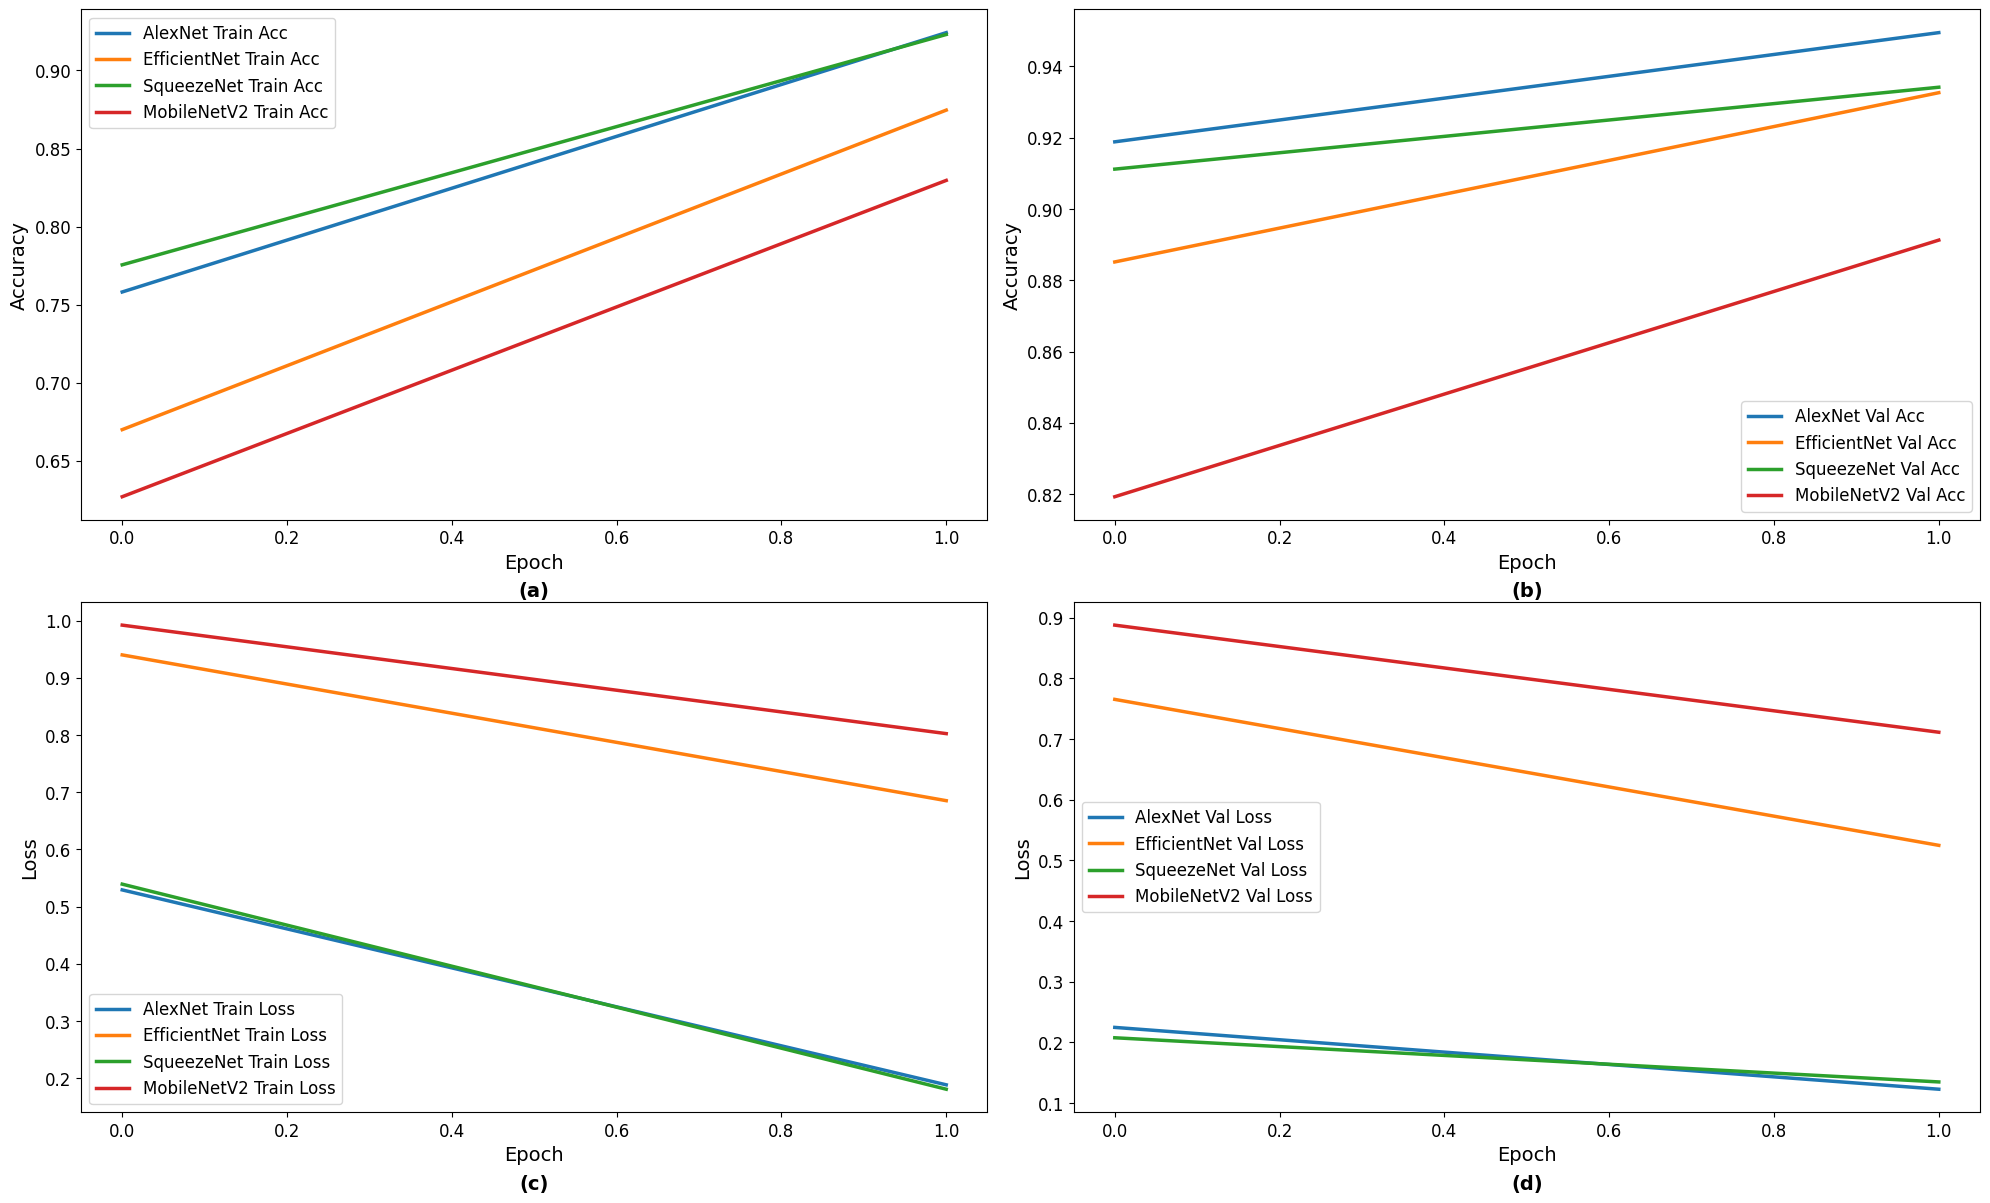

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

# Font size
fontsize_title = 16
fontsize_labels = 14
fontsize_ticks = 12
fontsize_legend = 12
fontsize_letter = 14  # Font size for the letters (a), (b), (c), (d)

# Line width
line_width = 2.5  # Adjust the line thickness here

# Plotting learning curves
plt.figure(figsize=(20, 12))

# Plot 1: Training Accuracy
ax1 = plt.subplot(2, 2, 1)
ax1.plot(alexnet_results["train_acc"], label='AlexNet Train Acc', linewidth=line_width)
ax1.plot(efficientnet_b0_results["train_acc"], label='EfficientNet Train Acc', linewidth=line_width)
ax1.plot(squeezenet_results["train_acc"], label='SqueezeNet Train Acc', linewidth=line_width)
ax1.plot(mobilenetv2_results["train_acc"], label='MobileNetV2 Train Acc', linewidth=line_width)
ax1.set_title('', fontsize=fontsize_title)
ax1.set_xlabel('Epoch', fontsize=fontsize_labels)
ax1.set_ylabel('Accuracy', fontsize=fontsize_labels)
ax1.tick_params(axis='both', which='major', labelsize=fontsize_ticks)
ax1.legend(fontsize=fontsize_legend)
# Add letter (a) below the x-axis label
ax1.text(0.5, -0.15, '(a)', transform=ax1.transAxes, fontsize=fontsize_letter, fontweight='bold', ha='center')

# Plot 2: Validation Accuracy
ax2 = plt.subplot(2, 2, 2)
ax2.plot(alexnet_results["val_acc"], label='AlexNet Val Acc', linewidth=line_width)
ax2.plot(efficientnet_b0_results["val_acc"], label='EfficientNet Val Acc', linewidth=line_width)
ax2.plot(squeezenet_results["val_acc"], label='SqueezeNet Val Acc', linewidth=line_width)
ax2.plot(mobilenetv2_results["val_acc"], label='MobileNetV2 Val Acc', linewidth=line_width)
ax2.set_title('', fontsize=fontsize_title)
ax2.set_xlabel('Epoch', fontsize=fontsize_labels)
ax2.set_ylabel('Accuracy', fontsize=fontsize_labels)
ax2.tick_params(axis='both', which='major', labelsize=fontsize_ticks)
ax2.legend(fontsize=fontsize_legend)
# Add letter (b) below the x-axis label
ax2.text(0.5, -0.15, '(b)', transform=ax2.transAxes, fontsize=fontsize_letter, fontweight='bold', ha='center')

# Plot 3: Training Loss
ax3 = plt.subplot(2, 2, 3)
ax3.plot(alexnet_results["train_loss"], label='AlexNet Train Loss', linewidth=line_width)
ax3.plot(efficientnet_b0_results["train_loss"], label='EfficientNet Train Loss', linewidth=line_width)
ax3.plot(squeezenet_results["train_loss"], label='SqueezeNet Train Loss', linewidth=line_width)
ax3.plot(mobilenetv2_results["train_loss"], label='MobileNetV2 Train Loss', linewidth=line_width)
ax3.set_title('', fontsize=fontsize_title)
ax3.set_xlabel('Epoch', fontsize=fontsize_labels)
ax3.set_ylabel('Loss', fontsize=fontsize_labels)
ax3.tick_params(axis='both', which='major', labelsize=fontsize_ticks)
ax3.legend(fontsize=fontsize_legend)
# Add letter (c) below the x-axis label
ax3.text(0.5, -0.15, '(c)', transform=ax3.transAxes, fontsize=fontsize_letter, fontweight='bold', ha='center')

# Plot 4: Validation Loss
ax4 = plt.subplot(2, 2, 4)
ax4.plot(alexnet_results["val_loss"], label='AlexNet Val Loss', linewidth=line_width)
ax4.plot(efficientnet_b0_results["val_loss"], label='EfficientNet Val Loss', linewidth=line_width)
ax4.plot(squeezenet_results["val_loss"], label='SqueezeNet Val Loss', linewidth=line_width)
ax4.plot(mobilenetv2_results["val_loss"], label='MobileNetV2 Val Loss', linewidth=line_width)
ax4.set_title('', fontsize=fontsize_title)
ax4.set_xlabel('Epoch', fontsize=fontsize_labels)
ax4.set_ylabel('Loss', fontsize=fontsize_labels)
ax4.tick_params(axis='both', which='major', labelsize=fontsize_ticks)
ax4.legend(fontsize=fontsize_legend)
# Add letter (d) below the x-axis label
ax4.text(0.5, -0.15, '(d)', transform=ax4.transAxes, fontsize=fontsize_letter, fontweight='bold', ha='center')

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

## Learning Validation Curves

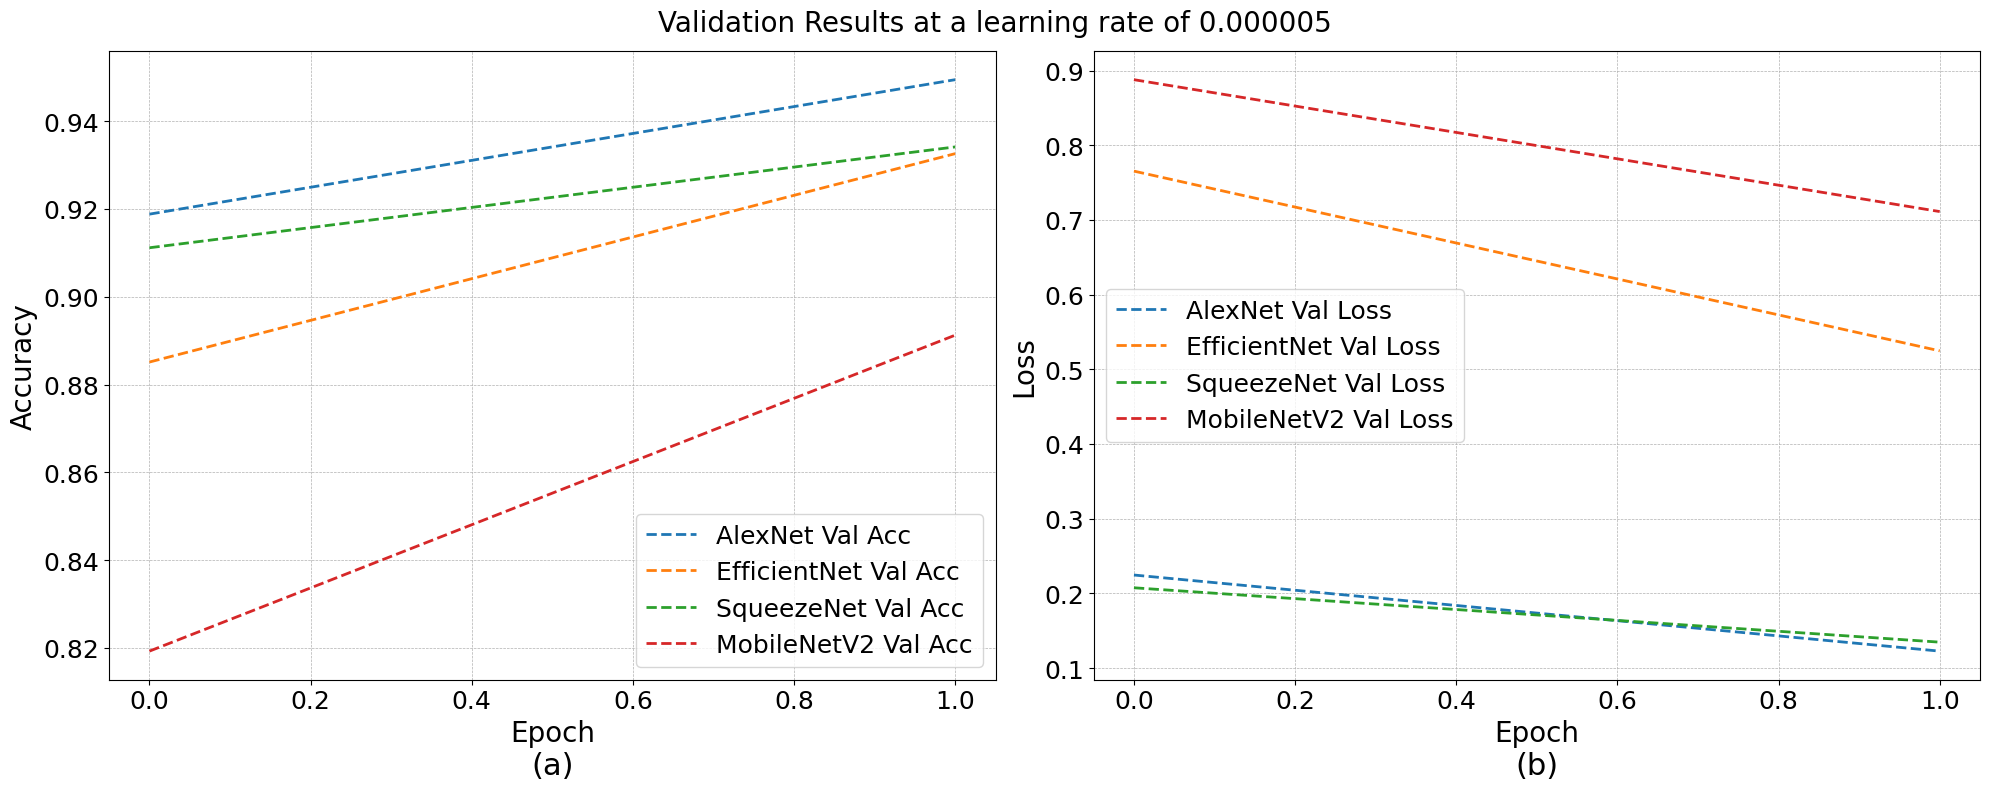

In [30]:
# Font size
fontsize_title = 20
fontsize_labels = 20
fontsize_ticks = 18
fontsize_legend = 18
fontsize_letter = 22  # Font size for the letters (a), (b), (c), (d)

# Line width
line_width = 2  # Adjust the line thickness here

# Plotting learning curves
plt.figure(figsize=(20, 8))

# Plot 1:  Validation Accuracy
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alexnet_results["val_acc"], label='AlexNet Val Acc', linestyle='--', linewidth=line_width)
ax1.plot(efficientnet_b0_results["val_acc"], label='EfficientNet Val Acc', linestyle='--', linewidth=line_width)
ax1.plot(squeezenet_results["val_acc"], label='SqueezeNet Val Acc', linestyle='--', linewidth=line_width)
ax1.plot(mobilenetv2_results["val_acc"], label='MobileNetV2 Val Acc', linestyle='--', linewidth=line_width)
ax1.set_title('', fontsize=fontsize_title)
ax1.set_xlabel('Epoch', fontsize=fontsize_labels)
ax1.set_ylabel('Accuracy', fontsize=fontsize_labels)
ax1.tick_params(axis='both', which='major', labelsize=fontsize_ticks)
ax1.legend(fontsize=fontsize_legend)
ax1.grid(True, axis='both', which='major', linestyle='--', linewidth=0.5)
# Add letter (a) below the x-axis label
ax1.text(0.5, -0.15, '(g)', transform=ax1.transAxes, fontsize=fontsize_letter, ha='center')

# Plot 2: Validation Loss
ax2 = plt.subplot(1, 2, 2)
ax2.plot(alexnet_results["val_loss"], label='AlexNet Val Loss', linestyle='--', linewidth=line_width)
ax2.plot(efficientnet_b0_results["val_loss"], label='EfficientNet Val Loss', linestyle='--', linewidth=line_width)
ax2.plot(squeezenet_results["val_loss"], label='SqueezeNet Val Loss', linestyle='--', linewidth=line_width)
ax2.plot(mobilenetv2_results["val_loss"], label='MobileNetV2 Val Loss', linestyle='--', linewidth=line_width)
ax2.set_title('', fontsize=fontsize_title)
ax2.set_xlabel('Epoch', fontsize=fontsize_labels)
ax2.set_ylabel('Loss', fontsize=fontsize_labels)
ax2.tick_params(axis='both', which='major', labelsize=fontsize_ticks)
ax2.legend(fontsize=fontsize_legend)
ax2.grid(True, axis='both', which='major', linestyle='--', linewidth=0.5)
# Add letter (b) below the x-axis label
ax2.text(0.5, -0.15, '(h)', transform=ax2.transAxes, fontsize=fontsize_letter, ha='center')

plt.suptitle('Validation Results at a learning rate of 0.005', fontsize=fontsize_title)
plt.tight_layout()  # Adjust the spacing between subplots
plt.savefig('AC-0.005.png', dpi=600, bbox_inches='tight')  # Save with 600 DPI
plt.show()


## Learning Training Curves

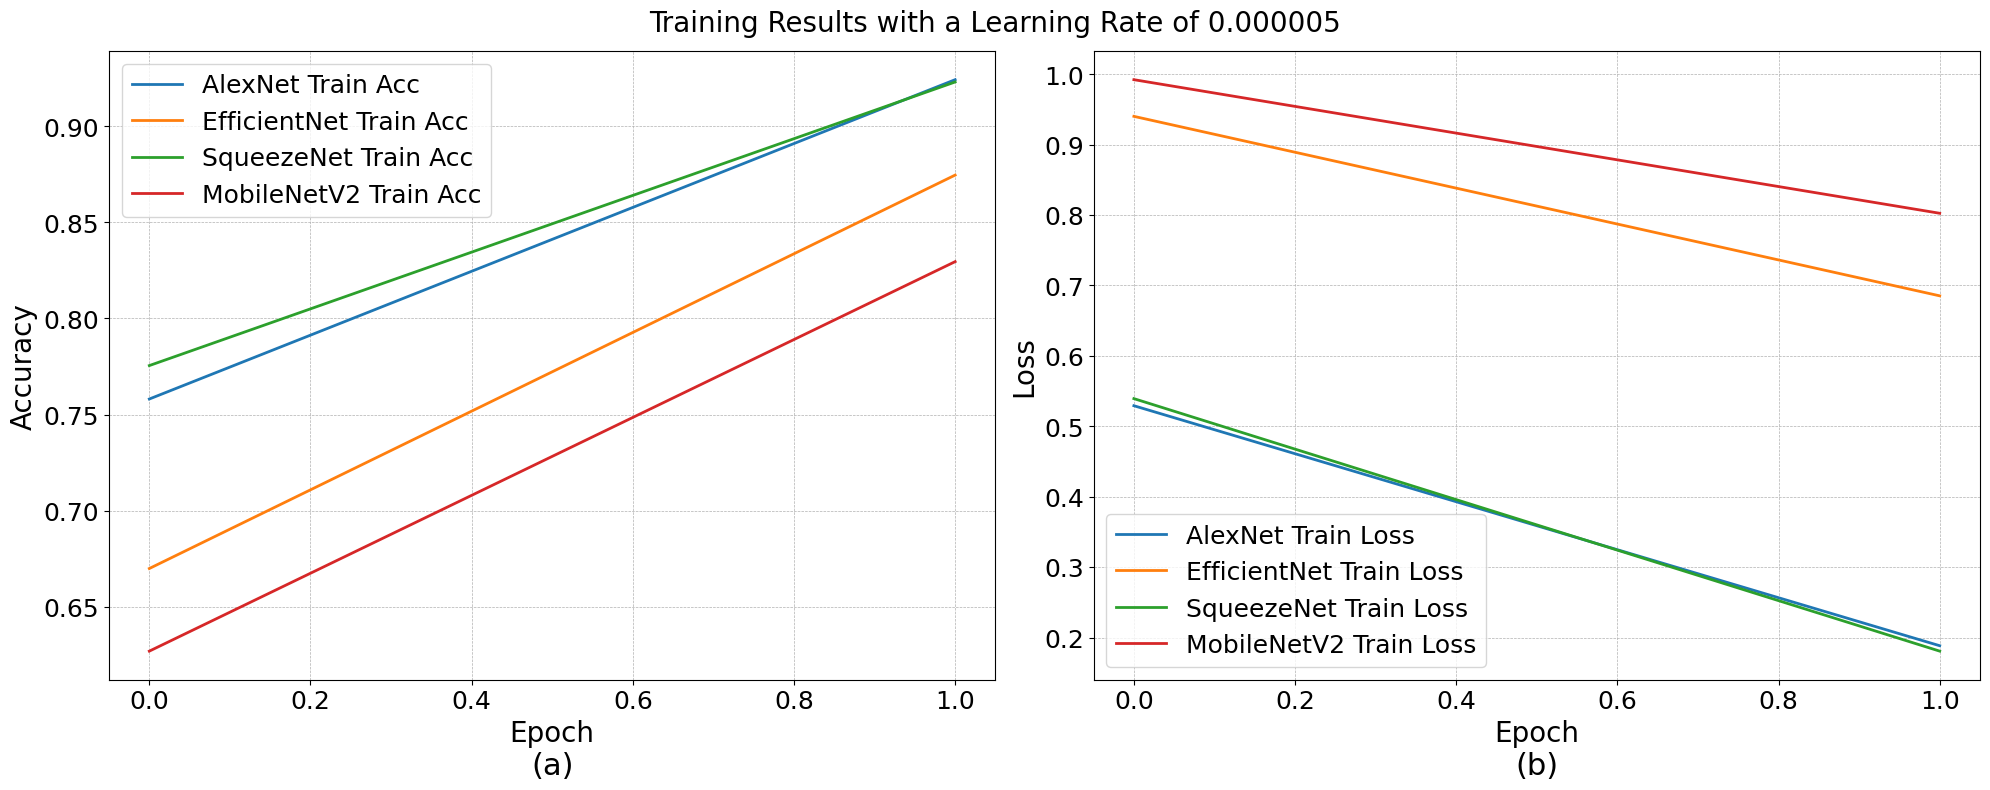

In [31]:

# Font size
fontsize_title = 20
fontsize_labels = 20
fontsize_ticks = 18
fontsize_legend = 18
fontsize_letter = 22  # Font size for the letters (a), (b), (c), (d)

# Line width
line_width = 2  # Adjust the line thickness here

# Plotting learning curves
plt.figure(figsize=(20, 8))

# Plot 1: Training and Validation Accuracy
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alexnet_results["train_acc"], label='AlexNet Train Acc', linewidth=line_width)
ax1.plot(efficientnet_b0_results["train_acc"], label='EfficientNet Train Acc', linewidth=line_width)
ax1.plot(squeezenet_results["train_acc"], label='SqueezeNet Train Acc', linewidth=line_width)
ax1.plot(mobilenetv2_results["train_acc"], label='MobileNetV2 Train Acc', linewidth=line_width)
ax1.set_title('', fontsize=fontsize_title)
ax1.set_xlabel('Epoch', fontsize=fontsize_labels)
ax1.set_ylabel('Accuracy', fontsize=fontsize_labels)
ax1.tick_params(axis='both', which='major', labelsize=fontsize_ticks)
ax1.legend(fontsize=fontsize_legend)
ax1.grid(True, axis='both', which='major', linestyle='--', linewidth=0.5)
# Add letter (a) below the x-axis label
ax1.text(0.5, -0.15, '(a)', transform=ax1.transAxes, fontsize=fontsize_letter, ha='center')

# Plot 2: Training and Validation Loss
ax2 = plt.subplot(1, 2, 2)
ax2.plot(alexnet_results["train_loss"], label='AlexNet Train Loss', linewidth=line_width)
ax2.plot(efficientnet_b0_results["train_loss"], label='EfficientNet Train Loss', linewidth=line_width)
ax2.plot(squeezenet_results["train_loss"], label='SqueezeNet Train Loss', linewidth=line_width)
ax2.plot(mobilenetv2_results["train_loss"], label='MobileNetV2 Train Loss', linewidth=line_width)
ax2.set_title('', fontsize=fontsize_title)
ax2.set_xlabel('Epoch', fontsize=fontsize_labels)
ax2.set_ylabel('Loss', fontsize=fontsize_labels)
ax2.tick_params(axis='both', which='major', labelsize=fontsize_ticks)
ax2.legend(fontsize=fontsize_legend)
ax2.grid(True, axis='both', which='major', linestyle='--', linewidth=0.5)
# Add letter (b) below the x-axis label
ax2.text(0.5, -0.15, '(b)', transform=ax2.transAxes, fontsize=fontsize_letter, ha='center')

plt.suptitle('Training Results with a Learning Rate of 0.005', fontsize=fontsize_title)
plt.tight_layout()  # Adjust the spacing between subplots
plt.savefig('AC2-0.005.png', dpi=600, bbox_inches='tight')  # Save with 600 DPI
plt.show()


## Confusion Matrix Comparation

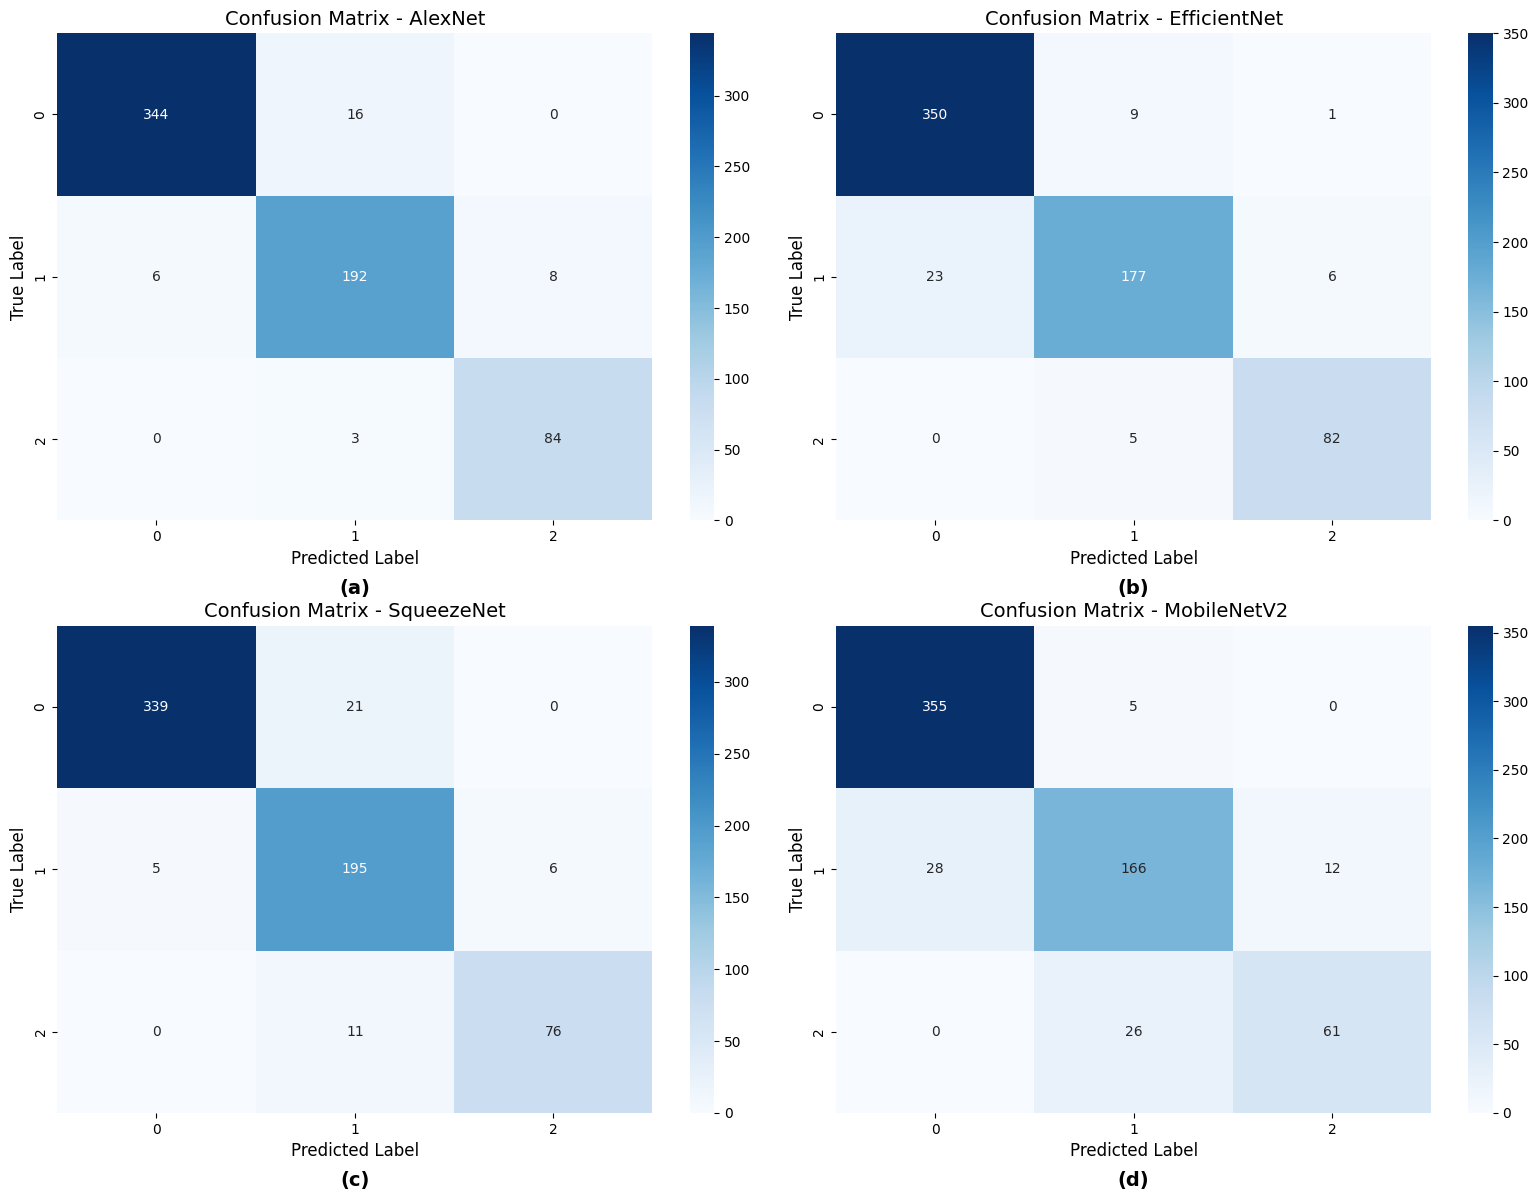

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Confusion matrix with seaborn
def plot_confusion_matrix(ax, conf_matrix, model_name):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues, 
                xticklabels=np.arange(conf_matrix.shape[1]),
                yticklabels=np.arange(conf_matrix.shape[0]), ax=ax)
    ax.set_title(f'Confusion Matrix - {model_name}', fontsize=14)
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)

# Create the figure and axes for subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))  # Adjust the size as needed

# Display confusion matrices in subplots
conf_matrix_alexnet = confusion_matrix(alexnet_results["all_labels_val"], alexnet_results["all_preds_val"])
conf_matrix_efficientnet = confusion_matrix(efficientnet_b0_results["all_labels_val"], efficientnet_b0_results["all_preds_val"])
conf_matrix_squeezenet = confusion_matrix(squeezenet_results["all_labels_val"], squeezenet_results["all_preds_val"])
conf_matrix_mobilenetv2 = confusion_matrix(mobilenetv2_results["all_labels_val"], mobilenetv2_results["all_preds_val"])

# Plot each confusion matrix in a different subplot
plot_confusion_matrix(axs[0, 0], conf_matrix_alexnet, "AlexNet")
plot_confusion_matrix(axs[0, 1], conf_matrix_efficientnet, "EfficientNet")
plot_confusion_matrix(axs[1, 0], conf_matrix_squeezenet, "SqueezeNet")
plot_confusion_matrix(axs[1, 1], conf_matrix_mobilenetv2, "MobileNetV2")

# Add letters (a), (b), (c), (d) below the x-axis labels
axs[0, 0].text(0.5, -0.15, '(a)', transform=axs[0, 0].transAxes, fontsize=14, fontweight='bold', ha='center')
axs[0, 1].text(0.5, -0.15, '(b)', transform=axs[0, 1].transAxes, fontsize=14, fontweight='bold', ha='center')
axs[1, 0].text(0.5, -0.15, '(c)', transform=axs[1, 0].transAxes, fontsize=14, fontweight='bold', ha='center')
axs[1, 1].text(0.5, -0.15, '(d)', transform=axs[1, 1].transAxes, fontsize=14, fontweight='bold', ha='center')

# Adjust layout to avoid overlaps
plt.tight_layout()
plt.show()


## ROC Curve comparation

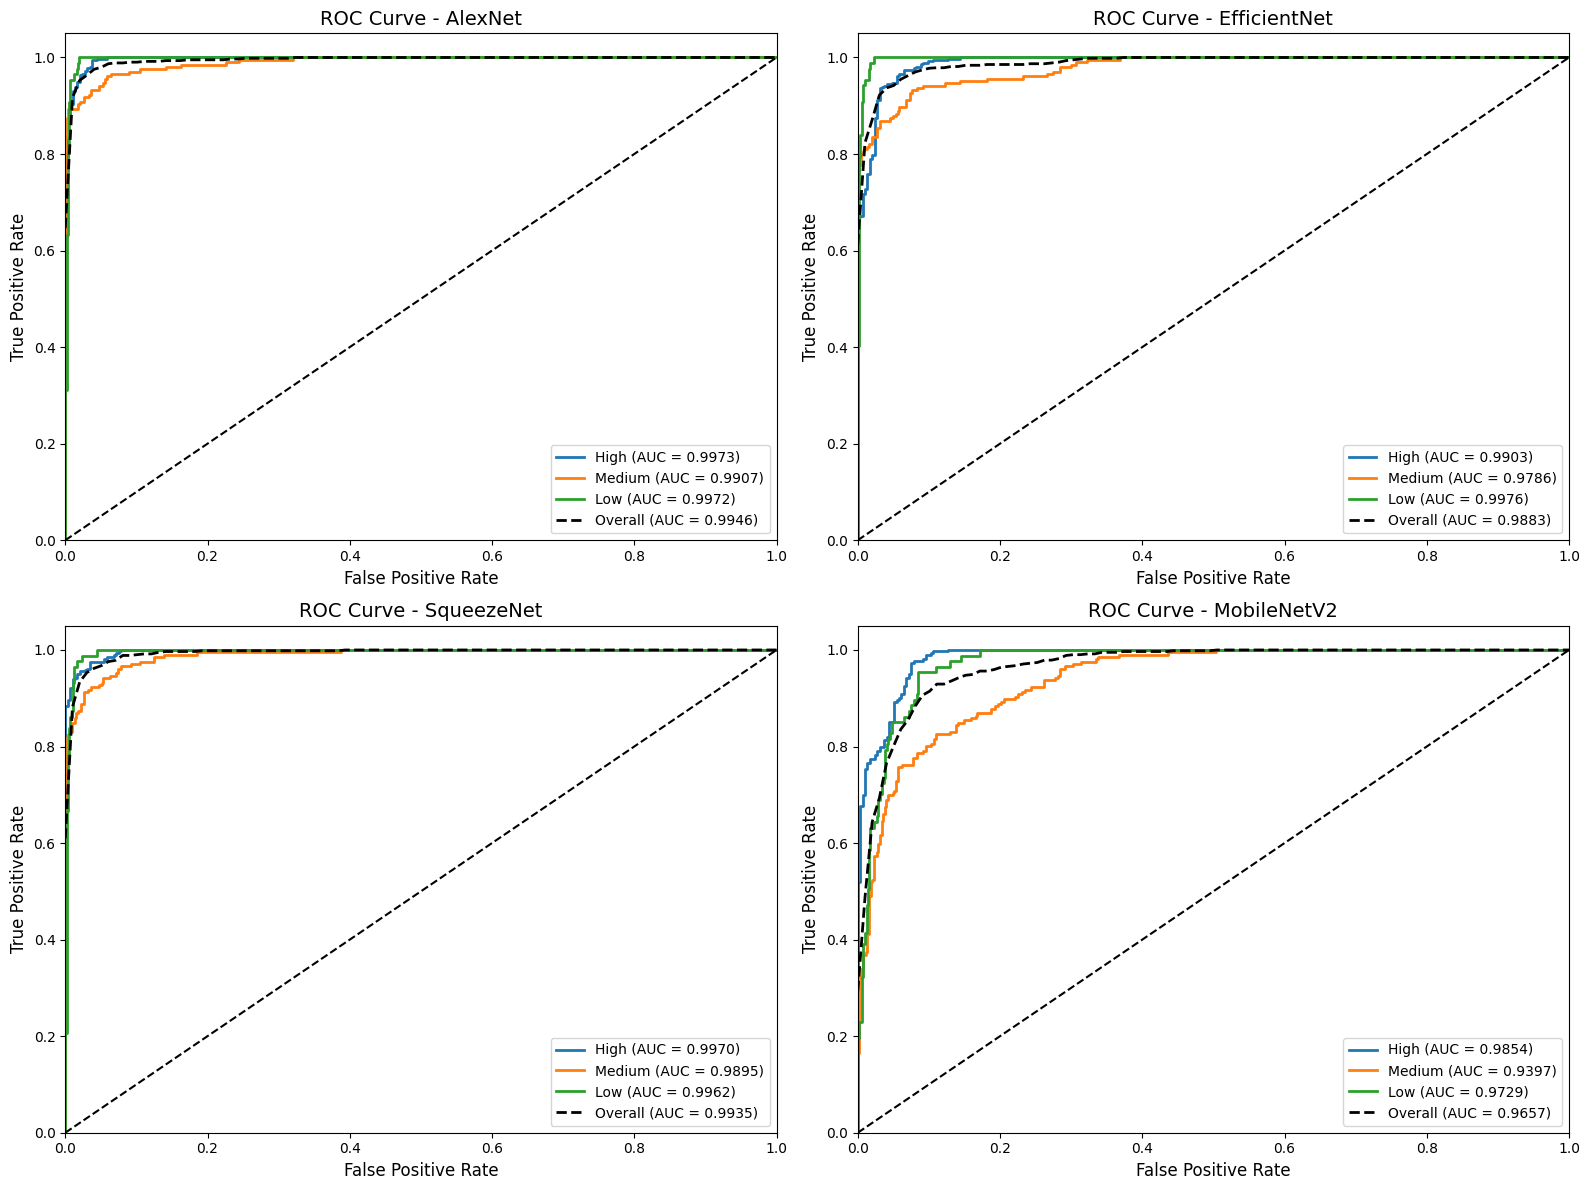

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# ROC Curves
def plot_roc_curve(ax, all_probs, all_labels, model_name, class_names):
    # Binarize the labels
    all_labels_bin = label_binarize(all_labels, classes=range(len(class_names)))
    
    # Initialize lists for ROC curves
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    # Calculate ROC curves for each class
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curves for each class
    for i in range(len(class_names)):
        ax.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.4f})', linewidth=2)
    
    # Calculate and plot the mean ROC curve
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)
    for i in range(len(class_names)):
        mean_tpr += np.interp(mean_fpr, fpr[i], tpr[i])
    mean_tpr /= len(class_names)
    mean_auc = auc(mean_fpr, mean_tpr)
    ax.plot(mean_fpr, mean_tpr, 'k--', label=f'Overall (AUC = {mean_auc:.4f})', linewidth=2)
    
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title(f'ROC Curve - {model_name}', fontsize=14)
    ax.legend(loc='lower right')

# Create the figure and axes for subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))  # Adjust the size as needed

# Define class names
class_names = ["High", "Medium", "Low"]

# Data for ROC curves (adjust the number of classes if necessary)
num_classes = len(class_names)

# Data for ROC curves
all_probs_alexnet = np.array(alexnet_results.get("all_probs_val", []))  # Ensure you have probabilities
all_labels_alexnet = np.array(alexnet_results.get("all_labels_val", []))
all_probs_efficientnet = np.array(efficientnet_b0_results.get("all_probs_val", []))
all_labels_efficientnet = np.array(efficientnet_b0_results.get("all_labels_val", []))
all_probs_squeezenet = np.array(squeezenet_results.get("all_probs_val", []))
all_labels_squeezenet = np.array(squeezenet_results.get("all_labels_val", []))
all_probs_mobilenetv2 = np.array(mobilenetv2_results.get("all_probs_val", []))
all_labels_mobilenetv2 = np.array(mobilenetv2_results.get("all_labels_val", []))

# Plot each ROC curve in a different subplot
plot_roc_curve(axs[0, 0], all_probs_alexnet, all_labels_alexnet, "AlexNet", class_names)
plot_roc_curve(axs[0, 1], all_probs_efficientnet, all_labels_efficientnet, "EfficientNet", class_names)
plot_roc_curve(axs[1, 0], all_probs_squeezenet, all_labels_squeezenet, "SqueezeNet", class_names)
plot_roc_curve(axs[1, 1], all_probs_mobilenetv2, all_labels_mobilenetv2, "MobileNetV2", class_names)

# Adjust layout to avoid overlaps
plt.tight_layout()
plt.show()


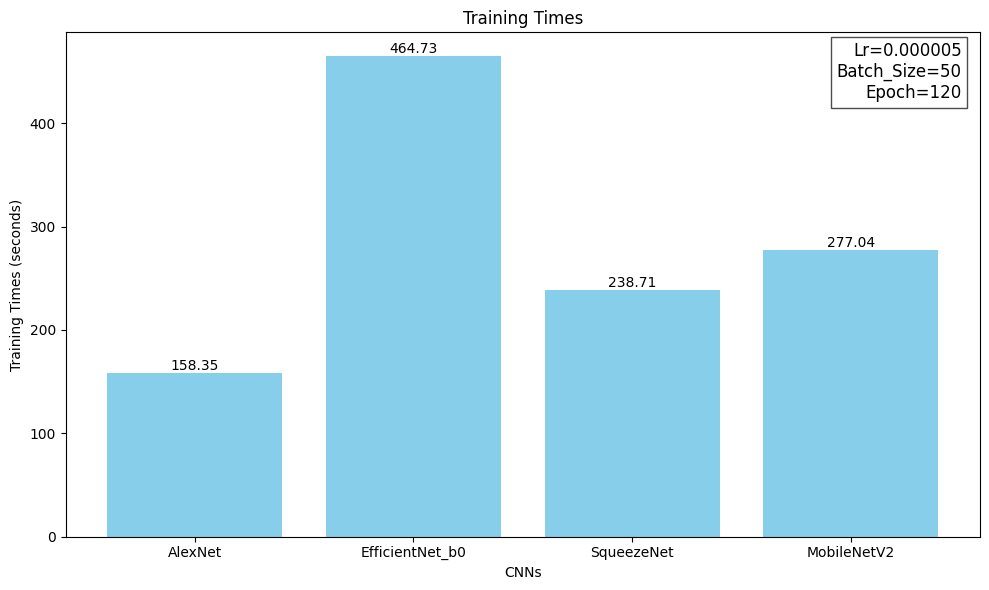

In [34]:
import matplotlib.pyplot as plt

# Values
tiempos = [alexnet_training_time, efficientnetb0_training_time, squeezenet_training_time, movilnetv2_training_time]
redes_names = ["AlexNet", "EfficientNet_b0", "SqueezeNet", "MobileNetV2"]

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(redes_names, tiempos, color='skyblue')

# Add title and labels
plt.title("Training Times")
plt.xlabel('CNNs')
plt.ylabel('Training Times (seconds)')

# Add values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), 
             ha='center', va='bottom', fontsize=10, color='black')

# Add annotation box
leyenda_texto = "Lr=0.005\nBatch_Size=50\nEpoch=120"
plt.text(0.98, 0.98, leyenda_texto, ha='right', va='top', fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'),
         transform=plt.gca().transAxes)  # Use axes coordinates

# Show the plot
plt.tight_layout()  # Ensure the layout looks good
plt.show()


In [36]:
import pandas as pd

# Assuming you have the validation metrics results for each model
squeezenet_val_metrics = {
    "Accuracy": accuracy_val_squeezenet,
    "Precision": precision_val_squeezenet,
    "Recall": recall_val_squeezenet,
    "F1-score": f1_val_squeezenet
}

alexnet_val_metrics = {
    "Accuracy": accuracy_val_alexnet,
    "Precision": precision_val_alexnet,
    "Recall": recall_val_alexnet,
    "F1-score": f1_val_alexnet
}

efficientnet_b0_val_metrics = {
    "Accuracy": accuracy_val_efficientnet_b0,
    "Precision": precision_val_efficientnet_b0,
    "Recall": recall_val_efficientnet_b0,
    "F1-score": f1_val_efficientnet_b0
}

mobilenetv2_val_metrics = {
    "Accuracy": accuracy_val_mobilenetv2,
    "Precision": precision_val_mobilenetv2,
    "Recall": recall_val_mobilenetv2,
    "F1-score": f1_val_mobilenetv2
}

# Training times
tiempos = [
    alexnet_training_time,
    efficientnetb0_training_time,
    squeezenet_training_time,
    movilnetv2_training_time
]

# Create the DataFrame
results_df = pd.DataFrame({
    'Model': ["AlexNet", "EfficientNet_b0", "SqueezeNet", "MobileNetV2"],
    'Training Time (s)': tiempos,
    'Accuracy': [
        alexnet_val_metrics["Accuracy"],
        efficientnet_b0_val_metrics["Accuracy"],
        squeezenet_val_metrics["Accuracy"],
        mobilenetv2_val_metrics["Accuracy"]
    ],
    'Precision': [
        alexnet_val_metrics["Precision"],
        efficientnet_b0_val_metrics["Precision"],
        squeezenet_val_metrics["Precision"],
        mobilenetv2_val_metrics["Precision"]
    ],
    'Recall': [
        alexnet_val_metrics["Recall"],
        efficientnet_b0_val_metrics["Recall"],
        squeezenet_val_metrics["Recall"],
        mobilenetv2_val_metrics["Recall"]
    ],
    'F1-score': [
        alexnet_val_metrics["F1-score"],
        efficientnet_b0_val_metrics["F1-score"],
        squeezenet_val_metrics["F1-score"],
        mobilenetv2_val_metrics["F1-score"]
    ]
})

# Display the DataFrame
print(results_df)


             Model  Training Time (s)  Accuracy  Precision    Recall  F1-score
0          AlexNet         158.351481  0.949464   0.950557  0.949464  0.949765
1  EfficientNet_b0         464.726627  0.932619   0.932403  0.932619  0.931927
2       SqueezeNet         238.705383  0.934150   0.937767  0.934150  0.934909
3      MobileNetV2         277.043809  0.891271   0.888153  0.891271  0.888293
